# Assignment 4 : Naive Bayes 


- Naive Bayes classification method is based on Bayes’ theorem. It is termed as ‘Naive’ because it assumes                independence between every pair of feature in the data. Let (x1, x2, …, xn) be a feature vector and y be the class        label corresponding to this feature vector.
           
           
          p(c/x) = (p(x/c) * p(c)) / (p(x))
           
           where: p(c/x) = posterior probability
                  p(x/c) = Likelihood
                  p(c)   = class prior probability
                  p(x)   = predictor prior probability
             
             
            p(c/X) = p(x1/c)*p(x2/c)*p(x3/c)......p(c)
 

- work well on numeric and text data
- Easy to implement and computation is good with comparing to other algorithm
- Assumes independence of features.
- Perform very poorly when features are highly correlated.
- Test time low so, better to use for low latency systems.

In [137]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [180]:
#Loading the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from wordcloud import WordCloud
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

In [139]:
#Loading the dataset
import pickle
def openfromfile(filename):
    temp = pickle.load(open(filename, "rb"))
    return temp

data_frame = openfromfile("New_Amazon_preprocess_data")

In [140]:
#shape of the dataframe
print("Shape of the Data Frame", data_frame.shape)

#first 5 rows of the dataframe
data_frame.head()

Shape of the Data Frame (364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
515425,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
24750,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
24749,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
308076,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,positive,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...,book easi read ingredi avail store unlik recip...
150523,150524,6641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...


In [141]:
#Columns of the data
data_frame.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

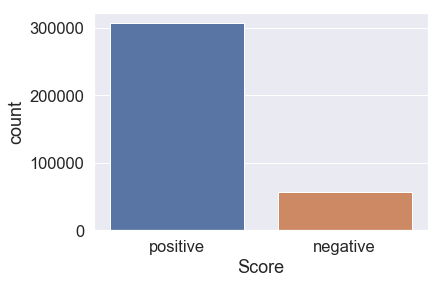

positive    307061
negative     57110
Name: Score, dtype: int64

In [142]:
sns.countplot(x=data_frame.Score, data=data_frame)
plt.show()
#Counts of positive and negative reviews
data_frame.Score.value_counts()

In [143]:
#Sorting the data based on the time attribute
data_frame.sort_values("Time", inplace=True)

#Resting the index of the data
data_frame = data_frame.reset_index(drop=True)

In [144]:
#For Score consisting of two categories making them as positive for 1 and negative for 0
data_frame.Score = [1 if (score == 'positive') else 0 for score in data_frame.Score]

In [145]:
#Storing CleanedText into X and Score into Y
X = data_frame.CleanedText
y = data_frame.Score

In [146]:
#splitting the data into train and test 
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [147]:
#Shape of train and test data
print("Shape of train data:", X_tr.shape)
print("Shape of test data:", X_test.shape)

Shape of train data: (254919,)
Shape of test data: (109252,)


# 1.BOW:

In [148]:

%%time

#Binary countvectorizer which means for non-zero counts make as 1, so vector contains values of 0's and 1's
count_vec = CountVectorizer(binary=True)
#Making the fit_transform for train data
bow_tr = count_vec.fit_transform(X_tr)

Wall time: 8.94 s


In [149]:
#Transform for test data
bow_test = count_vec.transform(X_test)

## BOW with Bernouli Naive Bayes: 

### Bernouli Naive Bayes: 
                             The binomial model is useful if your feature vectors are binary (i.e. zeros and ones). One application would be text classification with ‘bag of words’ model where the 1s & 0s are “word occurs in the document” and “word does not occur in the document” respectively.

**1.Grid Search cross validation** :
    - working through multiple combinations of parameter tunes, cross validate each and determine which one gives the best         performance.      
    
    - Note: In grid search, if you choosen n paramters then we will have to check 2^n combinations.

![title](grid search cross validation.png)

** Time based splitting:** Provides train/test indices to split time series data samplesthat are observed at fixed time                                intervals, in train/test sets.
                           In each split, test indices must be higher than before, and thus shuffling in cross validator is                            inappropriate.

![title](time series split.png)

In [150]:

%%time

#Bernouli Naive Bayes using grid Search Cross Validation for hyperparameter tuning.

#Giving some set of parameters as input to grid search cross validation
parameters = {'alpha':[10,5,1,0.5,0.1,0.05,0.01,0.005,0.001]}

#splitting the data based on time of 10 folds
tbs = TimeSeriesSplit(n_splits=10)

BNB = BernoulliNB()
gsv = GridSearchCV(BNB, parameters, scoring='accuracy', n_jobs=3, cv=tbs)

#Training the model
gsv.fit(bow_tr, y_tr)


print("optimal Alpha:",gsv.best_params_)
print("Train accuracy:",gsv.best_score_ * 100)

optimal Alpha: {'alpha': 0.01}
Train accuracy: 88.3537585224821
Wall time: 26.5 s


In [151]:
#gsv.grid_scores_ will return paramters, mean validation scores and cross validation scores
gsv.grid_scores_[:2]

[mean: 0.84717, std: 0.01983, params: {'alpha': 10},
 mean: 0.85142, std: 0.01654, params: {'alpha': 5}]

In [152]:
#Function for plot between alpha values and cv_errors
def alpha_cv_error(alpha_values, cv_errors):
    plt.plot(alpha_values, cv_errors)
    plt.title("alpha_values vs cv_errors")
    plt.xlabel("alpha_values")
    plt.ylabel("cv_errors")
    plt.show()

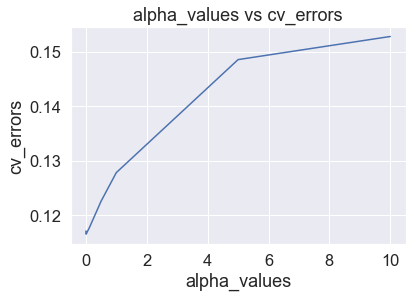

In [153]:
#Storing alpha_values from the gsv.grid_scores_
alpha = [val[0]['alpha'] for val in gsv.grid_scores_]
#Storing cv_errors into an cv_error 
cv_error = [1-val[1] for val in gsv.grid_scores_]

#Calling the function to plot between alpha_values and cv_errors
alpha_cv_error(alpha, cv_error)

** Testing the model using the best_estimator which can be return by grid_search_cv **

In [154]:
best_estimator = gsv.best_estimator_
#Parameters of best_estimator
best_estimator

BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)

In [155]:
#predicting the y_labels from the test data
y_pred = best_estimator.predict(bow_test)

In [156]:
#Function for test metrics
def test_metrics(y_test, y_pred):
    cm = pd.DataFrame(confusion_matrix(y_test,y_pred),range(2),range(2))
    sns.set(font_scale=1.5)
    sns.heatmap(cm,annot=True,annot_kws={"size": 20}, fmt='g', vmin=0, vmax=109252)

    print("Accuracy on test data:", round(accuracy_score(y_test, y_pred) * 100 , 2))
    print("Precision on test data:", round(precision_score(y_test, y_pred) * 100 , 2))
    print("Recall on test data:", round(recall_score(y_test, y_pred) * 100 , 2))
    print("F1_score on test data:", round(f1_score(y_test, y_pred) * 100,2))

    plt.show()

Accuracy on test data: 88.31
Precision on test data: 92.64
Recall on test data: 93.25
F1_score on test data: 92.94


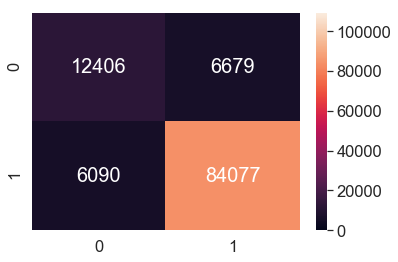

In [157]:
#Calling function for the test metrics
test_metrics(y_test, y_pred)

** As comparing to knn this classifier is predicting +ve review as +ve and -ve review as -ve, even though it is an imbalanced dataset.**

**2.Random Search cross validation:** 
- implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. 



- This has two main benefits over an exhaustive search:
    1. A budget can be chosen independent of the number of parameters and possible values
    2. Adding parameters that do not influence the performance does not decrease efficiency.
   



- Note: In random search, if you choosen n paramters then we will have to check n combinations.

![title](random search cross validation.png)

In [158]:

%%time

#Assigning the parameters
x = np.arange(0,10,0.01)
parameters = {'alpha': x}
#Time based Cross Validation with the 10 splits
tbs = TimeSeriesSplit(n_splits=10)

BNB = BernoulliNB()

#Bernouli Naive Bayes with the random Search
rsv = RandomizedSearchCV(BNB, parameters, scoring='accuracy', n_jobs=3, cv=tbs)
rsv.fit(bow_tr, y_tr)

print("Optimal Alpha:", rsv.best_params_)
print("Best accuracy:",rsv.best_score_*100)

Optimal Alpha: {'alpha': 0.58}
Best accuracy: 87.66246655734875
Wall time: 29.3 s


In [159]:
#rsv.grid_scores_ will return paramters, mean validation scores and cross validation scores
rsv.grid_scores_[:2]

[mean: 0.85681, std: 0.01358, params: {'alpha': 3.3000000000000003},
 mean: 0.84823, std: 0.01879, params: {'alpha': 7.55}]

In [160]:
#Testing the using best_estimator
best_estimator = rsv.best_estimator_

#Parameters of best_estimator
best_estimator

BernoulliNB(alpha=0.58, binarize=0.0, class_prior=None, fit_prior=True)

In [161]:
#predicting the y_labels from the test data
y_pred = best_estimator.predict(bow_test)

Accuracy on test data: 87.96
Precision on test data: 92.07
Recall on test data: 93.46
F1_score on test data: 92.76


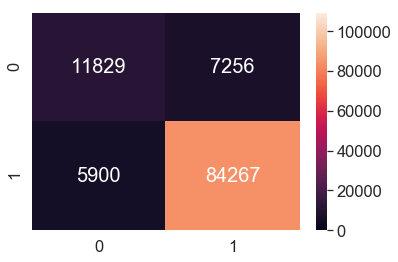

In [162]:
#Calling function for the test metrics
test_metrics(y_test, y_pred)

**Important features for positive class and negative class:**

- __feature_log_prob_ __ will Returns the log-probability of the samples for each class in the model. The columns correspond to the classes in sorted order, as they appear in the attribute classes_.

In [163]:
#Storing the negative class probability values 
neg_class_prob_sorted = best_estimator.feature_log_prob_ [0, :].argsort() #note: argsort will return the indices

#Storing the positive class probability values
pos_class_prob_sorted = best_estimator.feature_log_prob_[1, :].argsort()

In [164]:
print("Top 10 important features for positive class:")
#positve_important_words = np.take(count_vec.get_feature_names(), pos_class_prob_sorted)
print(np.take(count_vec.get_feature_names(), pos_class_prob_sorted[-10:]))


print("*"*50)

print("Top 10 important features for negative class:")
print(np.take(count_vec.get_feature_names(), neg_class_prob_sorted[-10:]))


Top 10 important features for positive class:
['product' 'tri' 'use' 'one' 'flavor' 'great' 'good' 'love' 'tast' 'like']
**************************************************
Top 10 important features for negative class:
['get' 'buy' 'good' 'flavor' 'tri' 'would' 'one' 'product' 'like' 'tast']


** Implementing Word Cloud:**

In [165]:
# #Forming an Empty String

# comment_words = ' '
# for word in positve_important_words:
#     comment_words = comment_words + word + ' '

In [166]:
# plt.figure(figsize=(10,10))
# wordcloud = WordCloud(background_color='white').generate(comment_words)
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.show()

# BOW with Multinomial Naive Bayes:

In [167]:

%%time


#BOW

count_vect = CountVectorizer()
bow_tr = count_vect.fit_transform(X_tr)

Wall time: 8.93 s


In [168]:

%%time

#Vectorizing the test data
bow_test = count_vect.transform(X_test)

Wall time: 3.6 s


** 1. Grid Search Cross Validation:**

In [169]:

%%time

#Multinomial Naive Bayes using grid Search Cross Validation for hyperparameter tuning.

#Giving some set of parameters as input to grid search cross validation
parameters = {'alpha':[10,5,1,0.5,0.1,0.05,0.01,0.005,0.001]}

#splitting the data based on time of 10 folds
tbs = TimeSeriesSplit(n_splits=10)

MNB = MultinomialNB()
gsv = GridSearchCV(MNB, parameters, scoring='accuracy', n_jobs=3, cv=tbs)

#Training the model
gsv.fit(bow_tr, y_tr)


print("optimal Alpha:",gsv.best_params_)
print("Train accuracy:",gsv.best_score_ * 100)

optimal Alpha: {'alpha': 0.5}
Train accuracy: 89.4653490981272
Wall time: 20.9 s


In [170]:
#gsv.grid_scores_ will return paramters, mean validation scores and cross validation scores
gsv.grid_scores_[:2]

[mean: 0.85319, std: 0.01586, params: {'alpha': 10},
 mean: 0.86802, std: 0.01165, params: {'alpha': 5}]

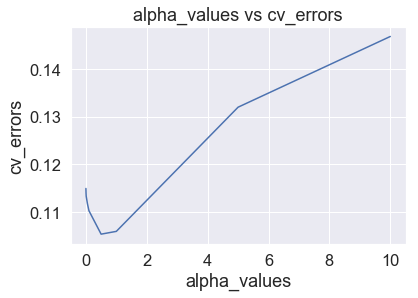

In [171]:
#Storing alpha_values from the gsv.grid_scores_
alpha = [val[0]['alpha'] for val in gsv.grid_scores_]
#Storing cv_errors into an cv_error 
cv_error = [1-val[1] for val in gsv.grid_scores_]

#Calling the function to plot between alpha_values and cv_errors
alpha_cv_error(alpha, cv_error)

** Testing the model using the best_estimator_ **

In [172]:
best_estimator = gsv.best_estimator_
#Parameters of best_estimator
best_estimator

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

In [173]:
#predicting the y_labels from the test data
y_pred = best_estimator.predict(bow_test)

Accuracy on test data: 89.5
Precision on test data: 93.57
Recall on test data: 93.71
F1_score on test data: 93.64


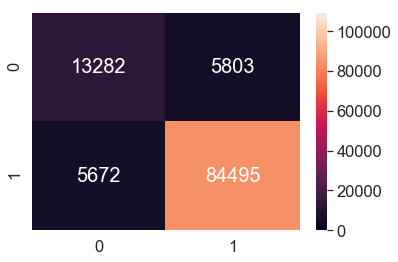

In [174]:
#Calling function for the test metrics
test_metrics(y_test, y_pred)

** 2. Random Search Cross Validation:**

In [175]:

%%time

#Assigning the parameters
x = np.arange(0,10,0.01)
parameters = {'alpha': x}
#Time based Cross Validation with the 10 splits
tbs = TimeSeriesSplit(n_splits=10)

MNB = MultinomialNB()

#Bernouli Naive Bayes with the random Search
rsv = RandomizedSearchCV(MNB, parameters, scoring='accuracy', n_jobs=3, cv=tbs)
rsv.fit(bow_tr, y_tr)

print("Optimal Alpha:", rsv.best_params_)
print("Best accuracy:",rsv.best_score_*100)

Optimal Alpha: {'alpha': 0.32}
Best accuracy: 89.36653145766807
Wall time: 22.2 s


In [176]:
#rsv.grid_scores_ will return paramters, mean validation scores and cross validation scores
rsv.grid_scores_[:2]

[mean: 0.89367, std: 0.00696, params: {'alpha': 0.32},
 mean: 0.86012, std: 0.01321, params: {'alpha': 6.95}]

In [177]:
#Testing the using best_estimator
best_estimator = rsv.best_estimator_

#Parameters of best_estimator
best_estimator

MultinomialNB(alpha=0.32, class_prior=None, fit_prior=True)

In [178]:
#predicting the y_labels from the test data
y_pred = best_estimator.predict(bow_test)

Accuracy on test data: 89.4
Precision on test data: 93.73
Recall on test data: 93.41
F1_score on test data: 93.57


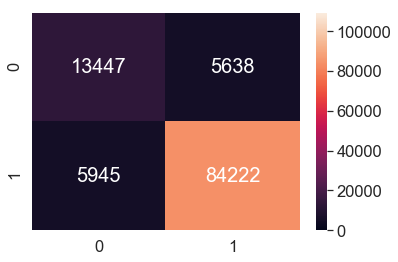

In [179]:
#Calling function for the test metrics
test_metrics(y_test, y_pred)

**Important features for positive class and negative class:**

- __feature_log_prob_ __ will Returns the log-probability of the samples for each class in the model. The columns correspond to the classes in sorted order, as they appear in the attribute classes_.

In [181]:
#Storing the negative class probability values 
neg_class_prob_sorted = best_estimator.feature_log_prob_ [0, :].argsort() #note: argsort will return the indices

#Storing the positive class probability values
pos_class_prob_sorted = best_estimator.feature_log_prob_[1, :].argsort()

In [182]:
print("Top 10 important features for positive class:")
#positve_important_words = np.take(count_vec.get_feature_names(), pos_class_prob_sorted)
print(np.take(count_vec.get_feature_names(), pos_class_prob_sorted[-10:]))


print("*"*50)

print("Top 10 important features for negative class:")
print(np.take(count_vec.get_feature_names(), neg_class_prob_sorted[-10:]))


Top 10 important features for positive class:
['tea' 'product' 'one' 'use' 'great' 'love' 'flavor' 'good' 'tast' 'like']
**************************************************
Top 10 important features for negative class:
['use' 'coffe' 'good' 'tri' 'would' 'flavor' 'one' 'product' 'like' 'tast']


# TFIDF: 

TF-IDF stands for term frequency-inverse document frequency. TF-IDF weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

Term_frequency(TF) = (number of times word occur in document) / (Total number of words in the document).

Inverse_Document_freqency(IDF) = log((total number of documents) / In which documents a word occurs))

                   So, TF-IDF(word) = TF(word) * IDF(word)

In [183]:
#Vectorizing the data
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_tr = tfidf_vect.fit_transform(X_tr)

In [184]:
#Vectorizing the test data
tfidf_test = tfidf_vect.transform(X_test)

** 1. Grid Search Cross Validation:**

In [185]:

%%time

#Multinomial Naive Bayes using grid Search Cross Validation for hyperparameter tuning.

#Giving some set of parameters as input to grid search cross validation
parameters = {'alpha':[10,5,1,0.5,0.1,0.05,0.01,0.005,0.001]}

#splitting the data based on time of 10 folds
tbs = TimeSeriesSplit(n_splits=10)

MNB = MultinomialNB()
gsv = GridSearchCV(MNB, parameters, scoring='accuracy', n_jobs=3, cv=tbs)

#Training the model
gsv.fit(tfidf_tr, y_tr)


print("optimal Alpha:",gsv.best_params_)
print("Train accuracy:",gsv.best_score_ * 100)

optimal Alpha: {'alpha': 0.01}
Train accuracy: 88.46293259687582
Wall time: 1min 1s


In [186]:
#gsv.grid_scores_ will return paramters, mean validation scores and cross validation scores
gsv.grid_scores_[:2]

[mean: 0.84690, std: 0.02047, params: {'alpha': 10},
 mean: 0.84690, std: 0.02047, params: {'alpha': 5}]

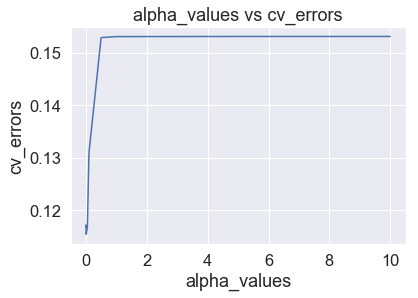

In [187]:
#Storing alpha_values from the gsv.grid_scores_
alpha = [val[0]['alpha'] for val in gsv.grid_scores_]
#Storing cv_errors into an cv_error 
cv_error = [1-val[1] for val in gsv.grid_scores_]

#Calling the function to plot between alpha_values and cv_errors
alpha_cv_error(alpha, cv_error)

** Testing the model using the best_estimator_ **

In [188]:
best_estimator = gsv.best_estimator_
#Parameters of best_estimator
best_estimator

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [189]:
#predicting the y_labels from the test data
y_pred = best_estimator.predict(tfidf_test)

Accuracy on test data: 89.15
Precision on test data: 89.14
Recall on test data: 98.91
F1_score on test data: 93.77


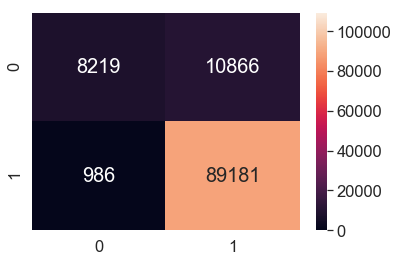

In [190]:
#Calling function for the test metrics
test_metrics(y_test, y_pred)

** 2. Random Search Algorithm:**

In [191]:

%%time

#Assigning the parameters
x = np.arange(0,10,0.01)
parameters = {'alpha': x}
#Time based Cross Validation with the 10 splits
tbs = TimeSeriesSplit(n_splits=10)

MNB = MultinomialNB()

#Bernouli Naive Bayes with the random Search
rsv = RandomizedSearchCV(MNB, parameters, scoring='accuracy', n_jobs=3, cv=tbs)
rsv.fit(tfidf_tr, y_tr)

print("Optimal Alpha:", rsv.best_params_)
print("Best accuracy:",rsv.best_score_*100)

Optimal Alpha: {'alpha': 0.17}
Best accuracy: 85.61577630102701
Wall time: 1min 7s


In [192]:
#rsv.grid_scores_ will return paramters, mean validation scores and cross validation scores
rsv.grid_scores_[:2]

[mean: 0.84690, std: 0.02047, params: {'alpha': 2.42},
 mean: 0.84690, std: 0.02047, params: {'alpha': 7.54}]

In [193]:
#Testing the using best_estimator
best_estimator = rsv.best_estimator_

#Parameters of best_estimator
best_estimator

MultinomialNB(alpha=0.17, class_prior=None, fit_prior=True)

In [194]:
#predicting the y_labels from the test data
y_pred = best_estimator.predict(tfidf_test)

Accuracy on test data: 84.28
Precision on test data: 84.02
Recall on test data: 99.96
F1_score on test data: 91.3


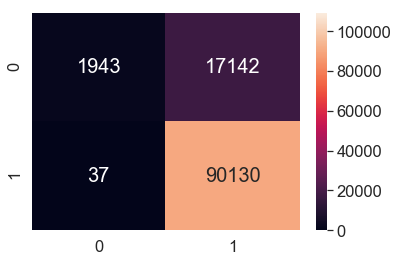

In [195]:
#Calling function for the test metrics
test_metrics(y_test, y_pred)

**Important features for positive class and negative class:**

- __feature_log_prob_ __ will Returns the log-probability of the samples for each class in the model. The columns correspond to the classes in sorted order, as they appear in the attribute classes_.

In [196]:
#Storing the negative class probability values 
neg_class_prob_sorted = best_estimator.feature_log_prob_ [0, :].argsort() #note: argsort will return the indices

#Storing the positive class probability values
pos_class_prob_sorted = best_estimator.feature_log_prob_[1, :].argsort()

In [198]:
print("Top 10 important features for positive class:")
#positve_important_words = np.take(count_vec.get_feature_names(), pos_class_prob_sorted)
print(np.take(tfidf_vect.get_feature_names(), pos_class_prob_sorted[-10:]))


print("*"*50)

print("Top 10 important features for negative class:")
print(np.take(tfidf_vect.get_feature_names(), neg_class_prob_sorted[-10:]))


Top 10 important features for positive class:
['product' 'use' 'coffe' 'flavor' 'good' 'like' 'tea' 'tast' 'love'
 'great']
**************************************************
Top 10 important features for negative class:
['order' 'buy' 'tri' 'one' 'coffe' 'flavor' 'would' 'product' 'like'
 'tast']


# Summary: 

**Naive Bayes Algorithm with different Cross Validation techniques:**


|               |sample size|Optimal_alpha|Grid Search CV  |             |op_alpha|    Random Search CV | 
|---------------|-----------|-------------|----------------|-------------|--------|---------------------|
|               |           |             |Train accuracy  |Test accuracy|        |Tain accuracy  |Test accuracy
|Binary BOW     |364k       |0.01         |88.35%          |88.31%       |0.58    |87.66%         |87.96%       
|Multinomail BOW|364k       |0.5          |89.46%          |89.50%       |0.32    |89.36%         |89.40%      
|TF-IDF         |364k       |0.01         |88.46%          |89.15%       |0.17    |85.61%         |84.28%

**Observation:**
               By comparing with above table, we can conclude that Muntinomail Naive Bayes with BOW is working                  good as compared to other algorithm.